**CHECKING PIXEL DISTRIBUTION**
---

***Our train and test dataset are drawn out of 3 different datasets***, which characteristic may vary (different sources ?). We need to check if the pixel distribution among the datasets are equivalent, as composition differ between train and test:<br>
  - ***train dataset*** : 1st datbase 29.6%, 2nd database 1.3% and 3rd database 69%.
  - ***test dataset*** : 1st dataset 0%, 2nd dataset 1.7% and 3er datase 98.3% 
  
If there are strong pixel distribution differences between datasets, we will need to transform images from 1st and 2nd database to look like images from the 3rd database (cf domain adapatation techniques), because our test dataset comes almost exclusively from the 3rd dataset (98.3%). 

Also we need to explore ***black and white images*** in the datases, as they would artificially alter the distribution. We create a specific function is_color_image(), to check this in both the train and test dataset.


In [30]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import pickle

In [31]:
#---------------------------------------
# DEFINE DEVICE
#---------------------------------------
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

#---------------------------------------
# DEFINE DATASET CLASS
#---------------------------------------

#class Dataset(torch.utils.data.Dataset): # in "starter notebook code" dataset is imported from torch.utils.data
class Dataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{self.image_dir}/{filename}")  
        X = self.transform(img)

        y = row['FaceOcclusion']     
        y = np.float32(y)

        gender = row['gender_id'] # changed to have round values 0 or 1

        return X, y, gender, filename

#--------------------------------------------------
# Compute mean and standard deviation on the pixels
#--------------------------------------------------

def calculate_mean_std(loader, num_channels=3):
    '''Calculate mean and standard deviation of the dataset.
    Args:
        loader: DataLoader object
        num_channels: number of channels
    Returns:
        mean: mean of the dataset (tensor)
        std: standard deviation of the dataset (tensor)
    '''
    channel_sum = torch.zeros(num_channels).to(device)
    channel_squared_sum = torch.zeros(num_channels).to(device)
    num_elements = 0

    for data, _, _, _ in loader:
        data = data.to(device)
        channel_sum += data.sum(dim=[0, 2, 3])
        channel_squared_sum += (data ** 2).sum(dim=[0, 2, 3])
        num_elements += data.size(0) * data.size(2) * data.size(3)

    mean = channel_sum / num_elements
    std = (channel_squared_sum / num_elements - mean ** 2) ** 0.5
    return mean, std

cuda


# LOAD IMAGES

In [32]:
# LOAD DATAFRAMES

with open('df_train.pkl', 'rb') as f: df_train = pickle.load(f)

with open('df_test.pkl', 'rb') as f: df_test = pickle.load(f)
# add columns to use the same Dataset class for df_train and df_test
df_test['FaceOcclusion'] = -1.0 # float
df_test['gender']= -1.0 # float
df_test['gender_id'] = -1 # integer

print(df_train.columns)
df_train.head(-5)

Index(['filename', 'FaceOcclusion', 'gender', 'initial_index', 'gender_id',
       'db_number', 'count', 'color', 'image_width', 'image_height',
       'channels', 'pixels', 'no_color'],
      dtype='object')


,filename,FaceOcclusion,gender,initial_index,gender_id,db_number,count,color,image_width,image_height,channels,pixels,no_color
0,database1/img00011271.jpg,0.019,0.999,0,1,1,1,1,224,224,3,50176,0
1,database1/img00012471.jpg,0.035,1.000,1,1,1,1,1,224,224,3,50176,0
2,database1/img00008127.jpg,0.127,0.001,2,0,1,1,1,224,224,3,50176,0
3,database1/img00008972.jpg,0.014,0.999,3,1,1,1,1,224,224,3,50176,0
4,database1/img00028187.jpg,0.346,0.982,4,1,1,1,1,224,224,3,50176,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101335,database3/database3/m.01drbr/73-FaceId-0_align...,0.290,0.999,101335,1,3,1,0,224,224,3,50176,1
101336,database3/database3/m.01drbr/76-FaceId-0_align...,0.005,1.000,101336,1,3,1,1,224,224,3,50176,0
101337,database3/database3/m.01drbr/79-FaceId-0_align...,0.105,1.000,101337,1,3,1,1,224,224,3,50176,0
101338,database3/database3/m.01drbr/80-FaceId-0_align...,0.241,0.999,101338,1,3,1,0,224,224,3,50176,1


# 1/ Explore weight of black and white images

In [33]:
# TRAIN - Distribution of color and black and white images (gray scale) in the 3 datasets

stats = df_train.groupby('db_number')['count','color','no_color','FaceOcclusion','gender_id'].sum()
stats.loc['Total'] = stats.sum()
stats['color_ratio'] = stats['color'] / stats['count']
stats['FaceOcclusion_ratio'] = stats['FaceOcclusion'] / stats['count'] # average FaceOcclusion
stats['color_ratio'] = stats['color_ratio'].map('{:.2%}'.format)
stats['gender_ratio'] = stats['gender_id'] / stats['count']
stats['gender_ratio'] = stats['gender_ratio'].map('{:.2%}'.format)
stats

/tmp/ipykernel_3132/2636741972.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats = df_train.groupby('db_number')['count','color','no_color','FaceOcclusion','gender_id'].sum()


,count,color,no_color,FaceOcclusion,gender_id,color_ratio,FaceOcclusion_ratio,gender_ratio
db_number,,,,,,,,
1,30000.0,30000.0,0.0,3426.257,10845.0,100.00%,0.114209,36.15%
2,1345.0,1234.0,111.0,174.677,717.0,91.75%,0.129871,53.31%
3,69996.0,56032.0,13964.0,5293.621,49352.0,80.05%,0.075627,70.51%
Total,101341.0,87266.0,14075.0,8894.555,60914.0,86.11%,0.087769,60.11%


In [34]:
# TEST DATASET - Distribution of color and black and white images (gray scale) in the 3 datasets

stats = df_test.groupby('db_number')['count','color','no_color'].sum()
stats.loc['Total'] = stats.sum()
stats['color_ratio'] = stats['color'] / stats['count']
stats['color_ratio'] = stats['color_ratio'].map('{:.2%}'.format)
stats

/tmp/ipykernel_3132/527400356.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats = df_test.groupby('db_number')['count','color','no_color'].sum()


,count,color,no_color,color_ratio
db_number,,,,
2,507,475,32,93.69%
3,30000,24151,5849,80.50%
Total,30507,24626,5881,80.72%


In [7]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# =======> Black and white images can be removed from the train datasets
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [35]:
# TRAIN - Distribution of color images (gray scale) in the 3 datasets

stats_color = df_train[df_train['color']==1].groupby('db_number')[['count','color','no_color','FaceOcclusion','gender_id']].sum()
stats_color.loc['Total'] = stats_color.sum()
stats_color['color_ratio'] = stats_color['color'] / stats_color['count']
stats_color['FaceOcclusion_ratio'] = stats_color['FaceOcclusion'] / stats_color['count'] # average FaceOcclusion
stats_color['color_ratio'] = stats_color['color_ratio'].map('{:.2%}'.format)
stats_color['gender_ratio'] = stats_color['gender_id'] / stats_color['count']
stats_color['gender_ratio'] = stats_color['gender_ratio'].map('{:.2%}'.format)
stats_color

,count,color,no_color,FaceOcclusion,gender_id,color_ratio,FaceOcclusion_ratio,gender_ratio
db_number,,,,,,,,
1,30000.0,30000.0,0.0,3426.257,10845.0,100.00%,0.114209,36.15%
2,1234.0,1234.0,0.0,164.645,640.0,100.00%,0.133424,51.86%
3,56032.0,56032.0,0.0,4320.100,39582.0,100.00%,0.077101,70.64%
Total,87266.0,87266.0,0.0,7911.002,51067.0,100.00%,0.090654,58.52%


# 2/ Explore color image pixel distribution

## 2.1/ Train dataset

In [55]:
# split dataframes by database source and take only color images
df = df_train[df_train['color']==1].reset_index(drop=True)
df_1 = df_train[(df_train['db_number'] == 1) & (df_train['color'] == 1)].reset_index(drop=True)
df_2 = df_train[(df_train['db_number'] == 2) & (df_train['color'] == 1)].reset_index(drop=True)
df_3 = df_train[(df_train['db_number'] == 3) & (df_train['color'] == 1)].reset_index(drop=True)

# print shapes
print('df shape:', df.shape)
print('df_1 shape:', df_1.shape)
print('df_2 shape:', df_2.shape)
print('df_3 shape:', df_3.shape)

# generate datasets for database 1 and 3
image_dir = 'Data/crops_100K'
set = Dataset(df, image_dir)
set_1 = Dataset(df_1, image_dir)
set_2 = Dataset(df_2, image_dir)
set_3 = Dataset(df_3, image_dir)

# Create DataLoaders
params = {'batch_size': 1024,
          'shuffle': False,
          'num_workers': 0}

loader = torch.utils.data.DataLoader(set, **params)
loader_1 = torch.utils.data.DataLoader(set_1, **params)
loader_2 = torch.utils.data.DataLoader(set_2, **params)
loader_3 = torch.utils.data.DataLoader(set_3, **params)

# compute mean and standard deviation for the color images in the 3 datasets
mean , std = calculate_mean_std(loader, num_channels=3)
print('train color - mean      ', mean.cpu().numpy(), 'std', std.cpu().numpy())
mean_1, std_1 = calculate_mean_std(loader_1, num_channels=3)
print('database 1 color - mean ', mean_1.cpu().numpy(), 'std', std_1.cpu().numpy())
mean_2, std_2 = calculate_mean_std(loader_2, num_channels=3)
print('database 2 color - mean ', mean_2.cpu().numpy(), 'std', std_2.cpu().numpy())
mean_3, std_3 = calculate_mean_std(loader_3, num_channels=3)
print('database 3 color - mean ', mean_3.cpu().numpy(), 'std', std_3.cpu().numpy())

df shape: (87266, 14)
df_1 shape: (30000, 14)
df_2 shape: (1234, 14)
df_3 shape: (56032, 14)
train color - mean       [0.55681306 0.43925527 0.38031614] std [0.28266945 0.24948709 0.24216673]
database 1 color - mean  [0.5637954  0.43052804 0.36255956] std [0.2892353  0.2503865  0.23815684]
database 2 color - mean  [0.5349409  0.4159749  0.35325104] std [0.3020055  0.26349074 0.25038993]
database 3 color - mean  [0.55355614 0.44444054 0.3904193 ] std [0.2785599  0.24852644 0.24351525]


### Compute mean and std deviation of each channel for each dataset

In [59]:
# concatenate dataset 1 + 2
df_12 = pd.concat([df_1, df_2])
df_12 = df_12.reset_index(drop=True)
set_12 = Dataset(df_12, image_dir)
loader_12 = torch.utils.data.DataLoader(set_12, **params)

mean_12, std_12 = calculate_mean_std(loader_12, num_channels=3)
print('database 1+2 color - mean ', mean_12.cpu().numpy(), 'std', std_12.cpu().numpy())
print('database 3 color - mean   ', mean_3.cpu().numpy(), 'std', std_3.cpu().numpy())

database 1+2 color - mean  [0.5626554  0.42995307 0.36219183] std [0.28980505 0.25093326 0.23865889]
database 3 color - mean    [0.55355614 0.44444054 0.3904193 ] std [0.2785599  0.24852644 0.24351525]


In [ ]:
# database 1 - mean  tensor([0.5623, 0.4301, 0.3626], device='cuda:0')
# database 1 - std tensor([0.2899, 0.2511, 0.2390], device='cuda:0')

# 2.2/ Test dataset

In [56]:
# split dataframes by database source and take only color images
df_test = df_test[df_test['color']==1].reset_index(drop=True)
df_1_test = df_test[(df_test['db_number'] == 1) & (df_test['color'] == 1)].reset_index(drop=True)
df_2_test = df_test[(df_test['db_number'] == 2) & (df_test['color'] == 1)].reset_index(drop=True)
df_3_test = df_test[(df_test['db_number'] == 3) & (df_test['color'] == 1)].reset_index(drop=True)

# print shapes
print('test df shape:', df_test.shape)
print('test df_1 shape:', df_1_test.shape)
print('test df_2 shape:', df_2_test.shape)
print('test df_3 shape:', df_3_test.shape)

# generate datasets for database 2 and 3
image_dir = 'Data/crops_100K'
set_test = Dataset(df_test, image_dir)
# set_1_test = Dataset(df_1_test, image_dir)
set_2_test = Dataset(df_2_test, image_dir)
set_3_test = Dataset(df_3_test, image_dir)

# Create DataLoaders
params = {'batch_size': 1024,
          'shuffle': False,
          'num_workers': 0}
loader_test = torch.utils.data.DataLoader(set_test, **params)
# loader_1 = torch.utils.data.DataLoader(set_1, **params)
loader_2_test = torch.utils.data.DataLoader(set_2_test, **params)
loader_3_test = torch.utils.data.DataLoader(set_3_test, **params)

# Compute mean and standard deviation of the pixels in color images in test dataset
mean_test , std_test = calculate_mean_std(loader_test, num_channels=3)
print('\ntest color - mean       ', mean_test.cpu().numpy(), 'std', std_test.cpu().numpy())
mean_2_test, std_2_test = calculate_mean_std(loader_2_test, num_channels=3)
print('database 2 color - mean ', mean_2_test.cpu().numpy(), 'std', std_2_test.cpu().numpy())
mean_3_test, std_3_test = calculate_mean_std(loader_3_test, num_channels=3)
print('database 3 color - mean ', mean_3_test.cpu().numpy(), 'std', std_3_test.cpu().numpy())

test df shape: (24626, 13)
test df_1 shape: (0, 13)
test df_2 shape: (475, 13)
test df_3 shape: (24151, 13)

test color - mean        [0.546068   0.43837228 0.38533455] std [0.28526616 0.25515932 0.24864335]
database 2 color - mean  [0.5148032  0.41072243 0.36299762] std [0.3153239  0.27922863 0.26618573]
database 3 color - mean  [0.5466831  0.43891606 0.3857739 ] std [0.28460854 0.25463304 0.24826565]


## 3/ by genre

In [57]:
image_dir = 'Data/crops_100K'

women = df_train[(df_train['gender_id'] == 0)&(df_train['color'] == 1)].reset_index(drop=True)
women_1 = women[ women['db_number'] == 1].reset_index(drop=True)
women_2 = women[ women['db_number'] == 2].reset_index(drop=True)
women_3 = women[ women['db_number'] == 3].reset_index(drop=True)

men = df_train[(df_train['gender_id'] == 1)&(df_train['color'] == 1)].reset_index(drop=True)
men_1 =men[ men['db_number'] == 1].reset_index(drop=True)
men_2 = men[men['db_number'] == 2].reset_index(drop=True)
men_3 = men[men['db_number'] == 3].reset_index(drop=True)

set_w = Dataset(women, image_dir)
set_w_1 = Dataset(women_1, image_dir)
set_w_2 = Dataset(women_2, image_dir)
set_w_3 = Dataset(women_3, image_dir)

set_m = Dataset(men, image_dir)
set_m_1 = Dataset(men_1, image_dir)
set_m_2 = Dataset(men_2, image_dir)
set_m_3 = Dataset(men_3, image_dir)

params = {'batch_size': 1024,
          'shuffle': False,
          'num_workers': 0}

loader_w = torch.utils.data.DataLoader(set_w, **params)
loader_w_1 = torch.utils.data.DataLoader(set_w_1, **params)
loader_w_2 = torch.utils.data.DataLoader(set_w_2, **params)
loader_w_3 = torch.utils.data.DataLoader(set_w_3, **params)
loader_m = torch.utils.data.DataLoader(set_m, **params)
loader_m_1 = torch.utils.data.DataLoader(set_m_1, **params)
loader_m_2 = torch.utils.data.DataLoader(set_m_2, **params)
loader_m_3 = torch.utils.data.DataLoader(set_m_3, **params)

# Pixel mean by gender and channel
print('\nWOMEN - PIXEL DISTRIBUTION ACCROSS DATASETS')
mean_w, std_w = calculate_mean_std(loader_w, num_channels=3)
print('women:    ', mean_w.cpu().numpy(), 'std', std_w.cpu().numpy())
mean_w_1, std_w_1 = calculate_mean_std(loader_w_1, num_channels=3)
print('women db1:', mean_w_1.cpu().numpy(), 'std', std_w_1.cpu().numpy())
mean_w_2, std_w_2 = calculate_mean_std(loader_m_2, num_channels=3)
print('women db2:', mean_w_2.cpu().numpy(), 'std', std_w_2.cpu().numpy())
mean_w_3, std_w_3 = calculate_mean_std(loader_w_3, num_channels=3)
print('women db3:', mean_w_3.cpu().numpy(), 'std', std_w_3.cpu().numpy())

print('\nMEN - PIXEL DISTRIBUTION ACCROSS DATASETS')
mean_m, std_m = calculate_mean_std(loader_m, num_channels=3)
print('men:    ', mean_m.cpu().numpy(), 'std', std_m.cpu().numpy())
mean_m_1, std_m_1 = calculate_mean_std(loader_m_1, num_channels=3)
print('men db1:', mean_m_1.cpu().numpy(), 'std', std_m_1.cpu().numpy())
mean_m_2, std_m_2 = calculate_mean_std(loader_m_2, num_channels=3)
print('men db2:', mean_m_2.cpu().numpy(), 'std', std_m_2.cpu().numpy())
mean_m_3, std_m_3 = calculate_mean_std(loader_m_3, num_channels=3)
print('men db3:', mean_m_3.cpu().numpy(), 'std', std_m_3.cpu().numpy())



WOMEN - PIXEL DISTRIBUTION ACCROSS DATASETS
women:     [0.5663897  0.4420299  0.37423137] std [0.2842709  0.25059035 0.2395299 ]
women db1: [0.57377017 0.43721    0.36410475] std [0.2888427  0.25140956 0.237155  ]
women db2: [0.5253696  0.40710264 0.3474076 ] std [0.2981118  0.25932735 0.24827269]
women db3: [0.55855876 0.44823802 0.38655362] std [0.27777538 0.24884431 0.24121183]

MEN - PIXEL DISTRIBUTION ACCROSS DATASETS

men: [0.5500244 0.4372884 0.3846294] std [0.28133184 0.24868338 0.24392666]
men db1: [0.5461774  0.41872615 0.3598304 ] std [0.28908795 0.24813004 0.23989168]
men db2: [0.5253696  0.40710264 0.3474076 ] std [0.2981118  0.25932735 0.24827269]
men db3: [0.5514772  0.44286242 0.3920259 ] std [0.2788585  0.24837685 0.24444811]


In [76]:
# DISTRIBUTION BY LEVEL OF OCCLUSION FOR WOMEN AND COLOR IMAGES
# -------------------------------------------------------------
list = np.arange(0 , 1 , 0.1).tolist()
df_train['occ_level'] = pd.cut(df_train['FaceOcclusion'], bins=list, labels=False)


df_color_w = df_train[ (df_train['color'] == 1) & (df_train['gender_id']==0)].reset_index(drop=True)
res = []
for i in range(0,10):
    df_ = df_color_w[df_color_w['occ_level'] == i].reset_index(drop=True)
    set_ = Dataset(df_, image_dir)
    loader_ = torch.utils.data.DataLoader(set_, **params)
    mean_, std_ = calculate_mean_std(loader_, num_channels=3)
    print(f'color, women, occlusion level {i}: mean {mean_.cpu().numpy()}, std {std_.cpu().numpy()}, {len(df_)} images')
    res.append([i, len(df_)] + mean_.cpu().numpy().tolist() + std_.cpu().numpy().tolist())

res_df = pd.DataFrame(res, columns=['occ_level','images', 'mean_R','mean_G','mean_B' ,'std_R','std_G','std_B'])
with open('pixel_distribution_train_color_w_occ_level.pkl', 'wb') as f: pickle.dump(res_df, f)
                                                   

color, women, occlusion level 0: mean [0.5771184  0.45563287 0.38917598], std [0.28269112 0.25121826 0.24201731], 15470 images
color, women, occlusion level 1: mean [0.56732756 0.43869033 0.36858016], std [0.28308097 0.24775174 0.2354804 ], 12384 images
color, women, occlusion level 2: mean [0.5459979  0.4225831  0.35457334], std [0.28528833 0.2492176  0.23634155], 5520 images
color, women, occlusion level 3: mean [0.5380704  0.41235062 0.34596163], std [0.29154342 0.25424272 0.23983368], 2237 images
color, women, occlusion level 4: mean [0.5101596  0.3951852  0.34012443], std [0.30822027 0.26905623 0.2500039 ], 251 images
color, women, occlusion level 5: mean [0.49181914 0.40398246 0.3642229 ], std [0.3078752  0.26975113 0.25469872], 20 images
color, women, occlusion level 6: mean [0.5748995  0.4025202  0.35526362], std [0.27476484 0.275585   0.2941789 ], 6 images
color, women, occlusion level 7: mean [0.5339146  0.5094275  0.40241918], std [0.28971347 0.27086028 0.24094361], 2 images

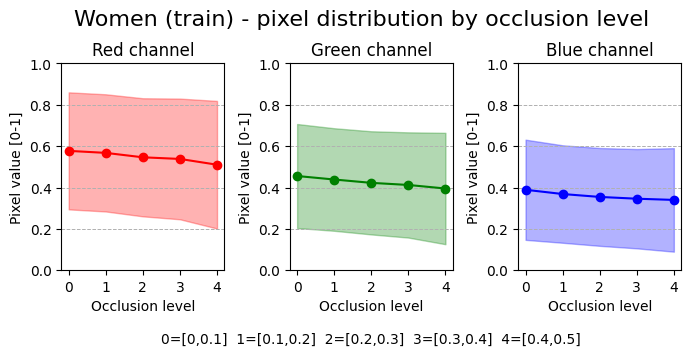

In [118]:
def plot_dist(res_df, title):
    res = res_df.iloc[:5,:] # take only first 5 occlusion levels
    plt.figure(figsize=(8,3))
    
    # red channel
    plt.subplot(1,3,1)
    plt.plot(res['occ_level'], res['mean_R'], color='r', marker='o', label='mean_R')
    plt.fill_between(res['occ_level'], res['mean_R']-res['std_R'], res['mean_R']+res['std_R'], color='r', alpha=0.3, label='std_R')
    plt.title('Red channel')
    plt.xlabel('Occlusion level')
    plt.xticks(res['occ_level'])
    plt.ylabel('Pixel value [0-1]')
    plt.ylim(0,1)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)

    # green channel
    plt.subplot(1,3,2)
    plt.plot(res['occ_level'], res['mean_G'], color='g', marker='o', label='mean_G')
    plt.fill_between(res['occ_level'], res['mean_G']-res['std_G'], res['mean_G']+res['std_G'], color='g', alpha=0.3, label='std_G')
    plt.title('Green channel')
    plt.xlabel('Occlusion level\n\n0=[0,0.1]  1=[0.1,0.2]  2=[0.2,0.3]  3=[0.3,0.4]  4=[0.4,0.5]')
    plt.xticks(res['occ_level'])
    plt.ylabel('Pixel value [0-1]')
    plt.ylim(0,1)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)

    # blue channel
    plt.subplot(1,3,3)
    plt.plot(res['occ_level'], res['mean_B'], color='b', marker='o', label='mean_B')
    plt.fill_between(res['occ_level'], res['mean_B']-res['std_B'], res['mean_B']+res['std_B'], color='b', alpha=0.3, label='std_B')
    plt.title('Blue channel')
    plt.xlabel('Occlusion level')
    plt.xticks(res['occ_level'])
    plt.ylabel('Pixel value [0-1]')
    plt.ylim(0,1)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)

    plt.subplots_adjust(top=0.8, wspace=0.4)
    plt.suptitle(title, fontsize=16)
    plt.show()

plot_dist(res_df,"Women (train) - pixel distribution by occlusion level")

# 3/ Normalize images ?

# NO - to avoid losing relationship between pixel levels and occultation

# 4/ PIXEL DISTRIBUTION OF THE FACE AREA (MASKED IMAGES)

TO BE DONE WITH MEDIAPIPE MASKS

# 4/ PIXEL DISTRIBUTION - COVARIANCE (2nd order statistics)

In [ ]:

# NORMALIZED DATA
#####################################

# MNIST
data = MNIST_train.data.to(device)
data = data.float() 
#reshape mnist data from 28x28 to 32x32 pixels
data = F.interpolate(data.unsqueeze(1), size=(32, 32), mode='nearest').squeeze(1)
data = data / 255
#print("mnist 32x32 shape",data.shape)
data = (data - mnist_mean) / mnist_std
mnist_norm_np_flat = data.reshape(data.shape[0], -1).cpu().numpy()

# SVHN grayscale (by averaging 3 channels into 1)
data = SVHN_train.data /255
#print(type(data))
data = torch.tensor(data, dtype=torch.float32).to(device)
data = torch.mean(data, axis=1)    # reduce to 1 channel
data = (data - svhn_mean) / svhn_std
data = data.reshape(data.shape[0], -1)
svhn_gray_norm_np_flat = data.cpu().numpy()

# SVHN  
data = SVHN_train.data / 255
data = torch.tensor(data, dtype=torch.float32).to(device)
data = (data - svhn_mean) / svhn_std
svhn_norm_np = data.cpu().numpy()
data = data.reshape(data.shape[0], -1)
svhn_norm_np_flat = data.cpu().numpy()

print("\nNormalised MNIST min, max & shape    :",mnist_norm_np_flat.shape, mnist_norm_np_flat.min(),mnist_norm_np_flat.max(), type(mnist_norm_np_flat))
print("Normalised SVHN gray min, max & shape:",svhn_gray_norm_np_flat.shape, svhn_gray_norm_np_flat.min(), svhn_gray_norm_np_flat.max(), type(svhn_gray_norm_np_flat))
print("Normalised SVHN min, max & shape     :",svhn_norm_np_flat.shape, svhn_norm_np_flat.min(),svhn_norm_np_flat.max(),type(svhn_norm_np_flat))


In [ ]:
#check normalisatoin for Red Green Blue channel of SVHN

print("\nSVHN (x3) mean, std   :",np.round(np.mean(svhn_norm_np_flat),8), np.std(svhn_norm_np_flat), svhn_norm_np_flat.shape)
print("- SVHN RED mean , std :",np.mean(svhn_norm_np_flat[:,:1024]), np.std(svhn_norm_np_flat[:,:1024]), svhn_norm_np_flat[:,:1024].shape)
print("- SVHN GREEN mean, std:",np.mean(svhn_norm_np_flat[:,1024:2048]), np.std(svhn_norm_np_flat[:,1024:2048]), svhn_norm_np_flat[:,1024:2048].shape)
print("- SVHN BLUE mean, std : ",np.mean(svhn_norm_np_flat[:,2048:]), np.std(svhn_norm_np_flat[:,2084,]), svhn_norm_np_flat[:,2048:].shape)

In [ ]:
########################################################
# print images to check normalisation
# values range from -inf to +inf => need to scale to 0-1
########################################################

def plot_images(images, title, color ='gray', scaled = 1):
    fig, axs = plt.subplots(1, 10, figsize=(8, 1))
    # standardize the range of the images with min or max
    for i in range(10):
        if scaled == 1:
            scaled_image = (images[i]/scale +0.5)
            # print('min max:', np.min(scaled_image),' - ', np.max(scaled_image))
            # klip the values to 0-1	
            scaled_image[scaled_image > 1] = 1
            scaled_image[scaled_image < 0] = 0
        else:
            scaled_image = images[i]
        axs[i].imshow(scaled_image, cmap= color) # scales images to range 0-1
        axs[i].axis('off')
    plt.suptitle(title, fontsize=14)
    plt.show()

high = max( np.max(mnist_norm_np_flat) , np.max(svhn_gray_norm_np_flat) , np.max(svhn_norm_np_flat) )
low = min( np.min(mnist_norm_np_flat) , np.min(svhn_gray_norm_np_flat), np.min(svhn_norm_np_flat) )
scale = max(abs(high), abs(low))
print("scale", scale)

# MNIST
mnist_norm_np = mnist_norm_np_flat.reshape(-1, 32, 32)
plot_images(mnist_norm_np, 'MNIST Normalized')

# SVHN grayscale
svhn_gray_norm_np = svhn_gray_norm_np_flat.reshape(-1, 32, 32)
plot_images(svhn_gray_norm_np, 'SVHN Grayscale Normalized')

# SVHN
svhn_np_transpose = SVHN_train.data.transpose((0, 2, 3, 1))/255
plot_images(svhn_np_transpose, 'SVHN Original', scaled = 0)

# SVHN
svhn_norm_np_transpose = svhn_norm_np.transpose((0, 2, 3, 1))
plot_images(svhn_norm_np_transpose, 'SVHN "Normalized globally"')
#show red channel in red, green in green and blue in blue
plot_images(svhn_norm_np_transpose[:,:,:,0], 'SVHN Normalized Red Channel', color ='Reds')
plot_images(svhn_norm_np_transpose[:,:,:,1], 'SVHN Normalized Green Channel', color ='Greens')
plot_images(svhn_norm_np_transpose[:,:,:,2], 'SVHN Normalized Blue Channel', color ='Blues')


In [ ]:
# SHOW 3 CORRELATION MATRICES (FLATTENED)
##########################################

cov_mnist_norm = np.cov(mnist_norm_np_flat, rowvar=False)
cov_svhn_gray_norm = np.cov(svhn_gray_norm_np_flat, rowvar=False)
cov_svhn_norm = np.cov(svhn_norm_np_flat, rowvar=False)

# covariance matrix is correlation matrix beacause the data is normalised

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5.5))  # 1 row, 3 columns
vmin = -1
vmax = 1
# MNIST Correlation Matrix
ax = axs[0]  # First subplot for MNIST
im = ax.imshow(cov_mnist_norm, cmap='coolwarm', interpolation='none',vmin=vmin, vmax=vmax)
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('MNIST - Covariance Matrix \n(1 channel 32x32=1024)')
#fig.colorbar(im, ax=ax, )

# SVHN grayscale Correlation Matrix
ax = axs[1]  # Second subplot for SVHN grayscale
im = ax.imshow(cov_svhn_gray_norm, cmap='coolwarm', interpolation='none',vmin=vmin, vmax=vmax)
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('SVHN Grayscale - Covariance Matrix \n(1 channel 32x32=1024)')
#fig.colorbar(im, ax=ax)

# SVHN Correlation Matrix
ax = axs[2]  # Third subplot for SVHN
im = ax.imshow(cov_svhn_norm, cmap='coolwarm', interpolation='none',vmin=vmin, vmax=vmax)
ax.set_title('SVHN RGB - Covariance Matrix \n(3 channels 32x32 = 3072)')
#fig.colorbar(im, ax=ax)
fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.025, pad=0.04)

# Display the subplots
plt.suptitle('Covariance Matrices (Flattened line by line)', fontsize=16)
plt.show()

**3/ APPLYING CORAL METHOD**
---
With the normalised data, we can now apply the CORAL method to align the source and target distributions. 

The steps are as follows:<br>
1/ Compute the square root of the inverse of the source covariance matrix.<br>
2/ Compute the whitened source data.<br>
3/ Compute the square root of the target covariance matrix.<br>
4/ Compute the aligned source data.<br>

In [ ]:
# FUNCTIONS TO APPLY CORAL METHOD
#################################

def get_whitening_matrix(cov, epsilon=1e-5):
    '''Compute the whitening matrix from the covariance matrix
    input : covariance matrix of SOURCE dataset, epsilon
    output : whitening matrix (size of covariance matrix)
    '''
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov + epsilon * np.eye(cov.shape[0]))

    # Compute the inverse of the square root of the eigenvalues
    inv_sqrt_eigvals = 1.0 / np.sqrt(eigvals)

    # Construct the whitening matrix
    whitening_matrix = np.dot(np.dot(eigvecs, np.diag(inv_sqrt_eigvals)), eigvecs.T)

    return whitening_matrix

def get_whitened_data(data, mean, whitening_matrix):
    '''denoise the data by centering and whitening it
    Input: flattenned np.array data, mean, whitening_matrix
    '''
    # Center the data
    centered_data = data - mean

    # Apply the whitening matrix
    whitened_data = np.dot(centered_data, whitening_matrix)

    return whitened_data   

def get_coloring_matrix(target_cov):
    # Compute the square root of the target covariance matrix
    eigvals, eigvecs = np.linalg.eigh(target_cov)
    eigvals[eigvals < 0] = 0  # Numerical stability
    sqrt_eigvals = np.diag(np.sqrt(eigvals))
    coloring_matrix = np.dot(eigvecs, np.dot(sqrt_eigvals, eigvecs.T))

    return coloring_matrix

def get_colored_data(data, mean, coloring_matrix):
    '''denoise the data by centering and coloring it
    Input: flattenned np.array data, mean, coloring_matrix
    '''
    # DO NOT center the data

    # Apply the coloring matrix
    colored_data = np.dot(data, coloring_matrix)

    return colored_data

# After whitening and coloring the mean and std of new data needs to be checked and adjusted
# shifts or scaling may have occured due to the use of eigenvalues and eigenvectors (not unique)

def adjust_mean_std_to_SVHN(data, data_mean, data_std, target_mean, target_std):
    """
    Adjusts the input data (NumPy array) to have the specified target mean and standard deviation,
    ensuring the output is a NumPy array.

    :param data: Input data as a NumPy array.
    :param data_mean: Mean of the input data.
    :param data_std: Standard deviation of the input data.
    :param target_mean: Target mean for the adjusted data.
    :param target_std: Target standard deviation for the adjusted data.
    :return: Adjusted data as a NumPy array.
    """

    print("colored data - shape, mean, std, min, max:",data.shape, np.mean(data), np.std(data), np.min(data), np.max(data))

    # Convert mean and std to numpy arrays for broadcasting if they aren't already
    data_mean = np.array(data_mean)
    data_std = np.array(data_std)
    target_mean = np.array(target_mean)
    target_std = np.array(target_std)
    
    # Adjust the data
    adjusted_data = ((data - data_mean) * (target_std / data_std)) + target_mean
    
    # Optionally, you can clip the adjusted data to ensure it's within a valid range, like [0, 1]
    adjusted_data = np.clip(adjusted_data, 0, 1)
    
    print("adjusted data - shape, mean, std, min, max:",adjusted_data.shape, np.mean(adjusted_data), np.std(adjusted_data), np.min(adjusted_data), np.max(adjusted_data))
    
    return adjusted_data

def apply_CORAL(source_data, target_data , target_mean=None, target_std=None):
    '''Apply CORAL method to source data to make it look like target data
    Input: = FLAT NORMALISED NP ARRAYS = source_data, target_data
    Output: source_data adjusted to look like target_data
    '''
    # Compute the covariance matrices
    cov_source = np.cov(source_data, rowvar=False)
    cov_target = np.cov(target_data, rowvar=False)

    # Compute the whitening and coloring matrices
    whitening_matrix = get_whitening_matrix(cov_source)
    coloring_matrix = get_coloring_matrix(cov_target)

    # Apply the whitening and coloring matrices
    source_whitened = get_whitened_data(source_data, np.mean(source_data, axis=0), whitening_matrix)
    source_colorized = get_colored_data(source_whitened, np.mean(target_data, axis=0), coloring_matrix)

    # Adjust the data to the target distribution
    if target_mean is not None and target_std is not None:
        source_colorized_adjusted = adjust_mean_std_to_SVHN(source_colorized, 
                        np.mean(source_colorized), np.std(source_colorized), 
                        target_mean, target_std)
    else:
        source_colorized_adjusted = adjust_mean_std_to_SVHN(source_colorized, 
                        np.mean(source_colorized), np.std(source_colorized), 
                        np.mean(target_data), np.std(target_data))

    return source_colorized_adjusted

In [ ]:
# DEMO - CORAL METHOD TO MNIST WITH GRAYSCALE SVHN
####################################################

gray_colored = apply_CORAL(mnist_norm_np_flat, svhn_gray_norm_np_flat, svhn_mean.cpu().numpy(), svhn_std.cpu().numpy()) # adjust to SVHN gray channel
plot_images(gray_colored.reshape(-1, 32, 32), 'MNIST Adjusted to SVHN Grayscale (1 channel)')

# DECOMPOSED CORAL METHOD TO MNIST WITH GRAYSCALE SVHN
########################################################

# Whiten & color & adjust MNIST
print('mnist_norm_np_flat shape:',mnist_norm_np_flat.shape)
whitening_matrix = get_whitening_matrix(cov_mnist_norm)
mnist_whitened = get_whitened_data(mnist_norm_np_flat, np.mean(mnist_norm_np_flat, axis=0), whitening_matrix)
coloring_matrix_gray = get_coloring_matrix(cov_svhn_gray_norm)
mnist_colorized_gray = get_colored_data(mnist_whitened, np.mean(svhn_gray_norm_np_flat, axis=0), coloring_matrix_gray)

# Adjust the data to the SVHN distirbution
mnist_like_svhn_gray = adjust_mean_std_to_SVHN(mnist_colorized_gray, 
                        np.mean(mnist_colorized_gray), np.std(mnist_colorized_gray), 
                        svhn_mean.cpu().numpy(), svhn_std.cpu().numpy())


# show images : whitened, colorized, adjusted
plot_images(mnist_whitened.reshape(-1, 32, 32), 'MNIST =Whitened= with MNIST')
plot_images(mnist_colorized_gray.reshape(-1, 32, 32), 'MNIST =Colorized= with SVHN Grayscale (1 channel)')
mnist_like_svhn_gray_img = mnist_like_svhn_gray.reshape(-1, 32, 32)
plot_images(mnist_like_svhn_gray_img, 'MNIST =Adjusted= to SVHN Grayscale (1 channel)')

In [ ]:
# APPLY CORAL METHOD TO MNIST TRAIN WITH SVHN 
# (3 channels - red, green, blue + Grayscale)
###############################################

# MNIST COLORIZED WITH SVHN 3 CHANNELS 
#-------------------------------------

# RED CHANNEL
red = svhn_norm_np_flat[:,:1024]
red_colored = apply_CORAL(mnist_norm_np_flat, red, svhn_mean_channels[0].cpu().numpy(), svhn_std_channels[0].cpu().numpy()) # adjust to SVHN red channel
red_colored_img = red_colored.reshape(-1, 32, 32)
plot_images(red_colored_img, 'MNIST Red Channel Adjusted to SVHN Red Channel','Reds')

# GREEN CHANNEL
green = svhn_norm_np_flat[:,1024:2048]
green_colored = apply_CORAL(mnist_norm_np_flat, green, svhn_mean_channels[1].cpu().numpy(), svhn_std_channels[1].cpu().numpy()) # adjust to SVHN green channel
green_colored_img = green_colored.reshape(-1, 32, 32)
plot_images(green_colored_img, 'MNIST Green Channel Adjusted to SVHN Green Channel','Greens')

# BLUE CHANNEL
blue = svhn_norm_np_flat[:,2048:]
blue_colored = apply_CORAL(mnist_norm_np_flat, blue, svhn_mean_channels[2].cpu().numpy(), svhn_std_channels[2].cpu().numpy()) # adjust to SVHN blue channel
blue_colored_img = blue_colored.reshape(-1, 32, 32)
plot_images(blue_colored_img, 'MNIST Blue Channel Adjusted to SVHN Blue Channel','Blues')

# (COMBINE RED GREEN BLUE CHANNELS)
mnist_colorized_RGB = np.zeros((len(mnist_norm_np_flat), 32, 32, 3))
mnist_colorized_RGB[:,:,:,0] = red_colored_img
mnist_colorized_RGB[:,:,:,1] = green_colored_img
mnist_colorized_RGB[:,:,:,2] = blue_colored_img
plot_images(mnist_colorized_RGB, 'MNIST Adjusted to SVHN RGB (3 channels)')

with open('mnist_colorized_RGB.pkl', 'wb') as f:
    pickle.dump(mnist_colorized_RGB, f)

# MNIST COLORIZED WITH SVHN GRAYSCALE
#-------------------------------------
gray = svhn_gray_norm_np_flat
gray_colored = apply_CORAL(mnist_norm_np_flat, gray, svhn_mean.cpu().numpy(), svhn_std.cpu().numpy()) # adjust to SVHN gray channel
gray_colored_img = gray_colored.reshape(-1, 32, 32)
plot_images(gray_colored_img, 'MNIST Adjusted to SVHN Grayscale (1 channel)')

with open('mnist_colorized_gray.pkl', 'wb') as f:
    pickle.dump(gray_colored_img, f)


In [ ]:
# APPLY CORAL METHOD TO MNIST TEST WITH SVHN 
# (3 channels - red, green, blue + Grayscale)
###############################################


# Load the MNIST test dataset
MNIST_test = datasets.MNIST(root='./mnist_data/', train=False, transform=transform_mnist, download=True)

# Normalize and flatten the MNIST test dataset
# --------------------------------------------
test = MNIST_test.data.to(device)
test = test.float()
test = F.interpolate(test.unsqueeze(1), size=(32, 32), mode='nearest').squeeze(1)
test = test / 255
test = (test - mnist_mean) / mnist_std # normalise with the train datset mean and std
test = test.reshape(test.shape[0], -1).cpu().numpy() # flatten
print("test shape, min, max, mean, std:",test.shape, np.min(test), np.max(test), np.mean(test), np.std(test))

# MNIST COLORIZED WITH SVHN 3 CHANNELS
#-------------------------------------

# RED CHANNEL
red_test = svhn_norm_np_flat[:,:1024]
red_colored_test = apply_CORAL(test, red_test, svhn_mean_channels[0].cpu().numpy(), svhn_std_channels[0].cpu().numpy()) # adjust to SVHN red channel
red_colored_test_img = red_colored_test.reshape(-1, 32, 32)
plot_images(red_colored_test_img, 'MNIST Test Red Channel Adjusted to SVHN Red Channel','Reds')

# GREEN CHANNEL
green_test = svhn_norm_np_flat[:,1024:2048]
green_colored_test = apply_CORAL(test, green_test, svhn_mean_channels[1].cpu().numpy(), svhn_std_channels[1].cpu().numpy()) # adjust to SVHN green channel
green_colored_test_img = green_colored_test.reshape(-1, 32, 32)
plot_images(green_colored_test_img, 'MNIST Test Green Channel Adjusted to SVHN Green Channel','Greens')

# BLUE CHANNEL
blue_test = svhn_norm_np_flat[:,2048:]
blue_colored_test = apply_CORAL(test, blue_test, svhn_mean_channels[2].cpu().numpy(), svhn_std_channels[2].cpu().numpy()) # adjust to SVHN blue channel
blue_colored_test_img = blue_colored_test.reshape(-1, 32, 32)
plot_images(blue_colored_test_img, 'MNIST Test Blue Channel Adjusted to SVHN Blue Channel','Blues')

# (COMBINE RED GREEN BLUE CHANNELS)
mnist_colorized_RGB_test = np.zeros((len(test), 32, 32, 3))
mnist_colorized_RGB_test[:,:,:,0] = red_colored_test_img
mnist_colorized_RGB_test[:,:,:,1] = green_colored_test_img
mnist_colorized_RGB_test[:,:,:,2] = blue_colored_test_img
plot_images(mnist_colorized_RGB_test, 'MNIST Test Adjusted to SVHN RGB (3 channels)')
with open('mnist_colorized_RGB_test.pkl', 'wb') as f:
    pickle.dump(mnist_colorized_RGB_test, f)

# MNIST COLORIZED WITH SVHN GRAYSCALE
#-------------------------------------
gray_test = svhn_gray_norm_np_flat
gray_colored_test = apply_CORAL(test, gray_test, svhn_mean.cpu().numpy(), svhn_std.cpu().numpy()) # adjust to SVHN gray channel
gray_colored_test_img = gray_colored_test.reshape(-1, 32, 32)
plot_images(gray_colored_test_img, 'MNIST Test Adjusted to SVHN Grayscale (1 channel)')
with open('mnist_colorized_gray_test.pkl', 'wb') as f:
    pickle.dump(gray_colored_test_img, f)



**4/ APPLYING CORAL METHOD WITH RANDMONESS**
---
We will apply the CORAL method to the 3 channels of the images and add randomness to the transformation.

In [ ]:
# APPLY CORAL METHOD TO MNIST WITH SVHN (TRAIN)
###############################################

# Apply random coeff from -1 (inversion) to 1 to each channel
red_coeff = np.random.rand(len(mnist_norm_np_flat))
green_coeff = np.random.rand(len(mnist_norm_np_flat))
blue_coeff = np.random.rand(len(mnist_norm_np_flat))

red_invert = np.random.choice([1, -1], len(mnist_norm_np_flat))
green_invert = np.random.choice([1, -1], len(mnist_norm_np_flat))
blue_invert = np.random.choice([1, -1], len(mnist_norm_np_flat))

new_red_colored_img = red_colored_img * red_coeff[:, None, None]*red_invert[:, None, None]
new_green_colored_img = green_colored_img * green_coeff[:, None, None]*green_invert[:, None, None]
new_blue_colored_img = blue_colored_img * blue_coeff[:, None, None]*blue_invert[:, None, None]

# Combine the 3 channels with random coefficients
new_mnist_colorized_RGB = np.zeros((len(mnist_norm_np_flat), 32, 32, 3))
new_mnist_colorized_RGB[:,:,:,0] = new_red_colored_img
new_mnist_colorized_RGB[:,:,:,1] = new_green_colored_img
new_mnist_colorized_RGB[:,:,:,2] = new_blue_colored_img

plot_images(new_mnist_colorized_RGB, 'MNIST Adjusted to SVHN RGB (3 channels)')



**5/VISUALISING CENTER CORRELATION WITH SPIRAL TRANSFORMATION OF IMAGE**
---
spiral goes clockwise from the center of the image to the edges.
starts in the center, goes to the top left corner, then to the top right corner, then to the bottom right corner, and finally to the bottom left corner, etc. untol edges are reached.

for each spiral will move 2n+1 to the left and the top, and then 2n+2 to the right and to the bottom

In [ ]:
# SPRIRAL FLATTENING
#####################################

def spiral_flatten_center_out(image):
    N = image.shape[0]
    output = np.zeros(N*N, dtype=image.dtype)
    x, y = N // 2 - 1, N // 2 - 1  # Start from the center for even dimensions
    dx, dy = 0, 1  # Initial direction: right
    steps = 1  # Initial steps in the current direction
    step_changes = 0  # Counts how many times we've changed steps
    index = 0  # Index for the output array

    for i in range(N * N):
        # Check if current position is valid
        if 0 <= x < N and 0 <= y < N:
            output[index] = image[x, y]
            index += 1
        # Move to the next position
        x, y = x + dx, y + dy
        steps -= 1
        # Change direction and update steps
        if steps == 0:
            dx, dy = -dy, dx  # Rotate direction
            step_changes += 1
            if step_changes % 2 == 0:
                steps = step_changes // 2 + 1
            else:
                steps = (step_changes + 1) // 2

    return output

#MNIST

data_np = MNIST_train.data.numpy()
print('MNIST size',data_np.shape)
n_images, height, width = data_np.shape
data_spiral = np.zeros((n_images, height * width), dtype=data_np.dtype) # Apply the spiral flattening to each image
for i in range(n_images):
    data_spiral[i, :] = spiral_flatten_center_out(data_np[i, :, :])
cov_mnist_spiral = np.cov(data_spiral, rowvar=False)

# SVHN grayscale (by adding 3 channels into 1)
data_np = SVHN_train.data # numpy array
data_np = np.mean(data_np, axis=1)
print("SVHN grayscale shape", data_np.shape)
n_images, height, width = data_np.shape
data_spiral = np.zeros((n_images, height * width), dtype=data_np.dtype) # Apply the spiral flattening to each channel of each image
for i in range(n_images):
    data_spiral[i, :] = spiral_flatten_center_out(data_np[i, :, :])
cov_SVHN_gray_spiral = np.cov(data_spiral, rowvar=False)

#SVHN

data_np = SVHN_train.data
print("SVHN shape", data_np.shape)
n_images, channels, height, width = data_np.shape
data_spiral = np.zeros((n_images, channels * height * width), dtype=data_np.dtype) # Apply the spiral flattening to each channel of each image
for i in range(n_images):
    for j in range(channels):  # data_np is [i,3, :, :] is an image
        data_spiral[i, j * height * width:(j + 1) * height * width] = spiral_flatten_center_out(data_np[i, j, :, :])
cov_SVHN_spiral = np.cov(data_spiral, rowvar=False)

# SHOW 3 CORRELATION MATRICES (SPIRAL FLATTENED CENTER OUT)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5.5))  # 1 row, 3 columns
vmin = -1
vmax = 1

# MNIST Correlation Matrix
ax = axs[0]  # First subplot for MNIST
im = ax.imshow(cov_mnist_spiral, cmap='coolwarm', interpolation='none', vmin=vmin, vmax=vmax)
ax.grid(True)
ax.set_xticks(np.arange(0, 784, 28))
ax.set_yticks(np.arange(0, 784, 28))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('MNIST Correlation Matrix \n(1 channel 28x28=784)')
#fig.colorbar(im, ax=ax)

# SVHN grayscale Correlation Matrix
ax = axs[1]  # Second subplot for SVHN grayscale
im = ax.imshow(cov_SVHN_gray_spiral, cmap='coolwarm', interpolation='none', vmin=vmin, vmax=vmax)
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('SVHN Grayscale Covariance Matrix \n(1 channel 32x32=1024)')
#fig.colorbar(im, ax=ax)

# SVHN Correlation Matrix
ax = axs[2]  # Third subplot for SVHN
im = ax.imshow(cov_SVHN_spiral, cmap='coolwarm', interpolation='none',vmin=vmin, vmax=vmax)
ax.grid(True)
ax.set_title('SVHN Correlation Matrix \n(3 channels 32x32 = 3072)')
#fig.colorbar(im, ax=ax)
fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.025, pad=0.04)
# Display the subplots
plt.suptitle('Correlation Matrices (Spiral Flattened Center Out)', fontsize=16)
plt.show()



In [ ]:
'''##############################################################
# TO APPLY WHITENING & COLORIZATION TO THE ORIGINAL IMAGES
##############################################################

#trasnformation to upload flattened preprocessed data
class FlattenTransform:
    def __call__(self, x):
        return x.view(-1)
    
transform_mnist = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor value in [0, 1]
    transforms.Resize((32, 32), interpolation=Image.NEAREST),  # Resize to 32x32
    transforms.Normalize(mnist_mean, mnist_std),  # Normalize with real mean and standard deviation
    FlattenTransform(),  # Flattens the images
])

transform_svhn = transforms.Compose([
    transforms.ToTensor(), # Convert to tensor value in [0, 1]
    transforms.Normalize(svhn_mean, svhn_std), # Normalize with real mean and standard deviation
    FlattenTransform(),  # Flattens the images
])

MNIST_train_flat = datasets.MNIST(root='./mnist_data/', train=True, transform = transform_mnist, download=True)
SVHN_train_flat = datasets.SVHN(root='./svhn_data/', split='train', transform = transform_svhn, download=True)

MNIST_train_loader_flat = DataLoader(MNIST_train_flat, batch_size=batch_size, shuffle=False)
SVHN_train_loader_flat = DataLoader(SVHN_train_flat, batch_size=batch_size, shuffle=False)

print("MNIST shape: ", MNIST_train_flat.data.shape)
print("SVHN shape: ", SVHN_train_flat.data.shape)'''

In [ ]:
# DOWNLOAD DATA 

# DOWNLOAD, RESIZE & NORMALIZE MNIST DATASET  (32x32x3 instead of originl 28x28x1)
'''
from torchvision import datasets, transforms
import torch

# Define the transform to resize the image to 32x32 and replicate to 3 channels
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
])

# Download and load the dataset with the defined transform
train_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset_source = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# DOWNLOAD, (RESIZE &) NORMALISE, SVHN DATASET (Stret View House Numbers)
train_dataset_target = datasets.SVHN(root='./svhn_data/', split='train', transform=transform, download=True) # transform to insure same shape and normalisation
test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)'''
